In [48]:
import time
import arviz
import numpy as np
import pandas as pd
import scipy.special as sp
import scipy.stats as sts
import stan
import nest_asyncio
nest_asyncio.apply() 

In [49]:
# Parameters
P = [3, 5, 1, 4]
N = 5 * 10 ** 4
SEED = 1729

#### **Implementation Notes**

What happens when we transform the probability $p$ of transmission using the logit function? We now have a value $\log\left(\frac{p}{1-p}\right)$, the log odds transmission occurring. That is to say, the logarithm of the value $\omega$ such that the ratio of the chances of the event occurring to not occurring is $\omega:1$. Suppose we add a real number $\log(\gamma)$ to this transformed probability. We now have $\log\left(\gamma\frac{p}{1-p}\right)$, which is to say our new odds are $\gamma \omega:1$, or that they odds of transmission occurring has changed by a factor of $\gamma$. We can use this approach to consider the impact of interventions (such as mask-wearing) in our model.

For now, we will assume that the masking wearing rate is known and a factor of an individual rather than a location, but that the impact of mask wearing is unknown. This is a strong and unreliable assumption, but makes a reasonable spring-board to jump into more realistic models.

In [50]:
# Ground truth
np.random.seed(SEED)

mask_wearer = np.random.binomial(1, 0.5, size=(N,))

true_transmission_rate_mu = np.random.beta(2, 10, len(P))
true_transmission_rate_std = np.sqrt(sts.invgamma.rvs(a=100, size=len(P)))
true_mask_impact = np.random.lognormal(-1, 0.5, len(P))
true_mask_impact_rep = np.repeat(true_mask_impact, P)
true_transmission_rate = np.concatenate([
    sp.expit(sp.logit(mu) + np.random.normal(0, std, p))
    for p, mu, std
    in zip(P, true_transmission_rate_mu, true_transmission_rate_std)
])

true_occurrence_rate_mu = np.random.beta(2, 10, len(P))
true_occurrence_rate_std = np.sqrt(sts.invgamma.rvs(a=50, size=len(P)))
true_occurrence_rate = np.concatenate([
    sp.expit(sp.logit(mu) + np.random.normal(0, std, p))
    for p, mu, std
    in zip(P, true_occurrence_rate_mu, true_occurrence_rate_std)
])

base_rate = np.random.beta(2, 10, 1)

In [51]:
# Simulate data
data = {}
# TODO: Add covariances between same type of activity
for p in range(sum(P)):
    occurrence = np.random.binomial(1, true_occurrence_rate[p], N)
    transmission_prob = sp.expit(sp.logit(true_transmission_rate[p]) +
                                 np.log(true_mask_impact_rep[p]) * mask_wearer)
    transmission = occurrence * np.random.binomial(1, transmission_prob)
    data[f'O{p+1}'] = occurrence
    data[f'T{p+1}'] = transmission

data['T0'] = np.random.binomial(1, base_rate, N)
X = pd.DataFrame(data)
z = X.loc[:, X.columns.str.startswith('T')].sum(axis=1)
y = (z > 0).astype(int)
X = X.loc[:, X.columns.str.startswith('O')]

In [53]:
c = np.array([i + 1 for i, p in enumerate(P) for __ in range(p)])

TODO: Optimise using transformed parameters.

In [54]:
# Stan model code
model_code = """
functions {
  real expit_gaussian_lpdf(real y, real logit_mu, real sigma2) {
    return log(1 / y + 1 / (1 - y)) - (logit(y) - logit_mu)^2 / (2 * sigma2);
  }
}
data {
  int<lower=0> N;                            // number of observations
  int<lower=0> P;                            // number of places
  int<lower=0> K;                            // number of classes
  int<lower=0, upper=1> X[N,P];              // activity occurrences
  int<lower=0, upper=1> y[N];                // transmission (tested positive)
  int<lower=1, upper=K> c[P];                // place classes
  int<lower=0, upper=1> m[N];                // masking-wearing
}
parameters {
  real<lower=0, upper=1> theta[P];           // transmission rates
  real<lower=0, upper=1> mu[K];              // class transmission means
  real<lower=0> sigma2[K];                   // class transmission variances
  real<lower=0, upper=1> rho;                // underlying risk
  real iota[K];                              // intervention impacts (log)
}
transformed parameters {
  // Pre-computation for efficiency
  real log1m_theta[P] = log1m(theta);
  real log1m_theta_int[P];
  real log1m_rho = log1m(rho);
  real logit_mu[K] = logit(mu);
  
  for (p in 1:P) {
    log1m_theta_int[p] = log1m_inv_logit(logit(theta[p]) + iota[c[p]]);
  }
}
model {
  // Priors
  mu ~ beta(1, 5);
  sigma2 ~ inv_gamma(10, 1);
  rho ~ beta(1, 3);
  iota ~ normal(-1, 1);
  // Likelihood (classes)
  for (p in 1:P) {
    theta[p] ~ expit_gaussian(logit_mu[c[p]], sigma2[c[p]]);
  }
  // Likelihood (observations)
  for (n in 1:N) {
    real s = 0.0;
    for (p in 1:P) {
      if (X[n,p] == 1) {
        if (m[n] == 1) {
          s += log1m_theta_int[p];
        } else {
          s += log1m_theta[p];
        }
      }
    }
    s += log1m_rho;
    if (y[n] == 1) {
      target += log1m_exp(s);
    } else {
      target += s;
    }
  }
}
""" 

INFO:pystan:COMPILING THE C++ CODE FOR MODEL tt_mod_opt_61d024f320a60bc063cc9be713ca9455 NOW.


In [6]:
# Build model
model_data = {'N': N, 'P': sum(P), 'K': len(P), 
              'X': X.to_numpy(), 'y': y.to_numpy(), 
              'c': c, 'm': mask_wearer}
posterior = stan.build(model_code, data=model_data, random_seed=1)

Building... This may take some time.
Done.


In [ ]:
# Set NUTS parameters
nuts_samples = 5000
nuts_burnin = 1000
nuts_chains = 8

# Posterior sampling
start = time.time()
fit = posterior.sample(num_samples=nuts_samples, num_warmup=nuts_burnin, num_chains=nuts_chains)
print(f"{time.time() - start:.02f} seconds elapsed")

In [35]:
# Set model parameters
nuts_samples = 1000
nuts_burnin = 500
chains = 4

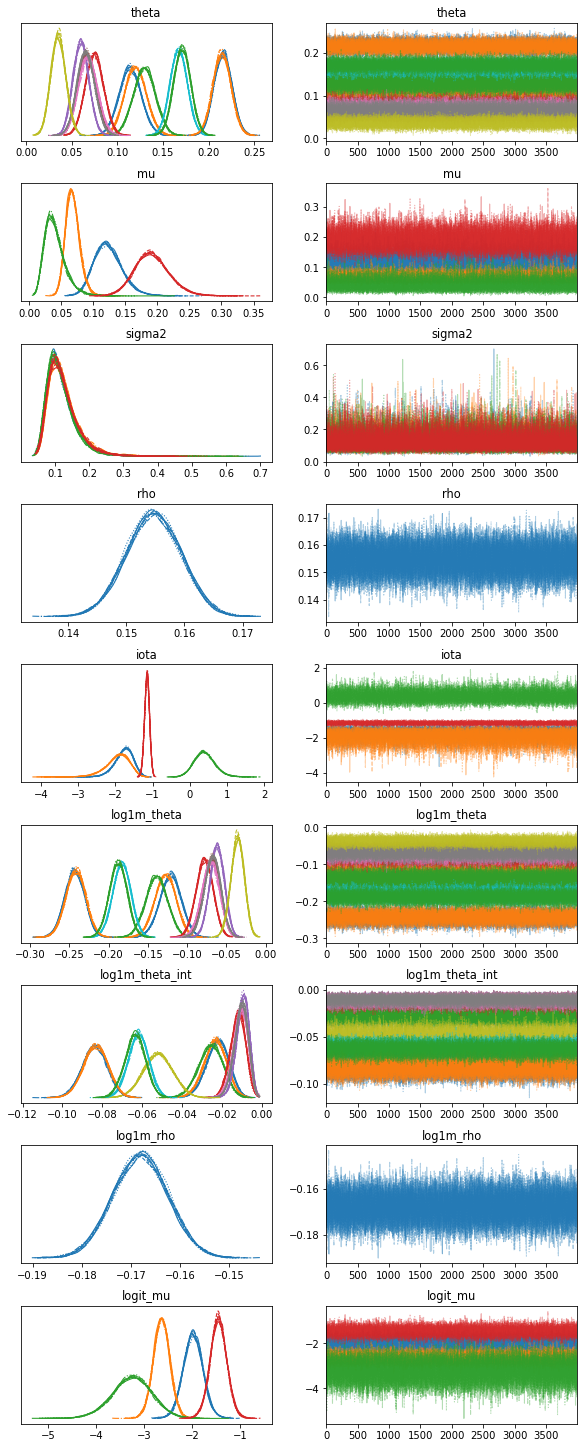

In [61]:
# Evaluate fit
arviz.plot_trace(fit, figsize=(8, 20));

In [16]:
fit = fit.to_frame()
print("Inference on fitted model:")
fit.describe().T

Inference on fitted model:


,count,mean,std,min,25%,50%,75%,max
parameters,,,,,,,,
lp__,16000.0,-6244.083799,2.600639e+00,-6255.381160,-6245.592456,-6243.674758,-6242.175793,-6239.241258
accept_stat__,16000.0,0.940213,6.522104e-02,0.538875,0.915272,0.960406,0.986669,1.000000
stepsize__,16000.0,0.361898,8.265869e-14,0.361898,0.361898,0.361898,0.361898,0.361898
treedepth__,16000.0,3.458000,5.042340e-01,2.000000,3.000000,3.000000,4.000000,4.000000
n_leapfrog__,16000.0,12.108000,3.964507e+00,3.000000,7.000000,15.000000,15.000000,31.000000
divergent__,16000.0,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
energy__,16000.0,6249.594005,3.572676e+00,6240.867771,6247.054267,6249.271710,6251.676799,6264.177631
theta.1,16000.0,0.181797,3.058368e-02,0.089707,0.162426,0.181668,0.202333,0.284292
theta.2,16000.0,0.190226,1.966616e-02,0.128776,0.177035,0.190416,0.203350,0.246257


In [58]:
# View results
print('Ground truth:')
print(true_transmission_rate)
print(true_transmission_rate_mu)
print(true_transmission_rate_std)
print(base_rate)
print(np.log(true_mask_impact))

Inference on original model:
Inference for Stan model: tt_mod_opt_61d024f320a60bc063cc9be713ca9455.
8 chains, each with iter=5000; warmup=1000; thin=1; 
post-warmup draws per chain=4000, total post-warmup draws=32000.

                       mean se_mean     sd   2.5%    25%     50%     75%   97.5%  n_eff   Rhat
theta[1]               0.11  5.7e-5   0.01   0.09   0.11    0.11    0.12    0.14  44732    1.0
theta[2]               0.12  5.6e-5   0.01    0.1   0.11    0.12    0.13    0.14  44297    1.0
theta[3]               0.13  5.7e-5   0.01   0.11   0.12    0.13    0.14    0.15  44306    1.0
theta[4]               0.07  4.8e-5 9.9e-3   0.06   0.07    0.07    0.08    0.09  43609    1.0
theta[5]               0.06  4.1e-5 8.6e-3   0.04   0.05    0.06    0.07    0.08  43301    1.0
theta[6]               0.07  4.5e-5 9.8e-3   0.05   0.06    0.07    0.07    0.09  47622    1.0
theta[7]               0.07  4.7e-5   0.01   0.05   0.06    0.07    0.07    0.09  47175    1.0
theta[8]             

In [59]:
np.sum((np.mean(fit.extract()['mu'], axis=0) - true_transmission_rate_mu) ** 2)

0.0002012009166741966